In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [4]:
test.head()

id  vendor_id      pickup_datetime  passenger_count  \
0  id3004672          1  2016-06-30 23:59:58                1   
1  id3505355          1  2016-06-30 23:59:53                1   
2  id1217141          1  2016-06-30 23:59:47                1   
3  id2150126          2  2016-06-30 23:59:41                1   
4  id1598245          1  2016-06-30 23:59:33                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  
0                  N  
1                  N  
2                  N  
3                  N  
4                  N

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# Data Preparation
## Trip Duration Clean-up
Deal with **outliers** associated with the `trip_duration` variable  
Exclude data that lies outside 2 standard deviations from the mean. 

In [6]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

## Check latitude/longitude bounds
Latitude: -85 to +85, Longitude: -180 to +180

In [7]:
print('Latitude bounds: {} to {}'.format(
    max(train.pickup_latitude.min(), train.dropoff_latitude.min()),
    max(train.pickup_latitude.max(), train.dropoff_latitude.max())
))

Latitude bounds: 34.359695434570305 to 51.88108444213867


In [8]:
print('Longitude bounds: {} to {}'.format(
    max(train.pickup_longitude.min(), train.dropoff_longitude.min()),
    max(train.pickup_longitude.max(), train.dropoff_longitude.max())
))

Longitude bounds: -121.9333038330078 to -61.33552932739258


## Latitude and Longitude Clean-up

Below shows the borders of NY City by Google Map.  
Then get the border ranges in coordinates.

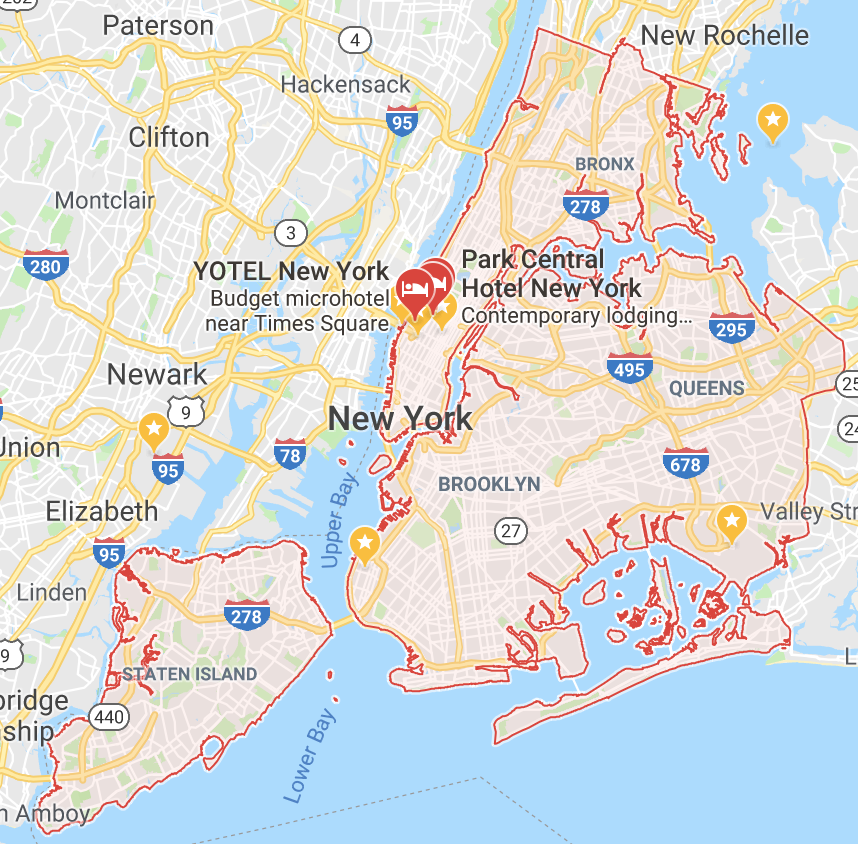

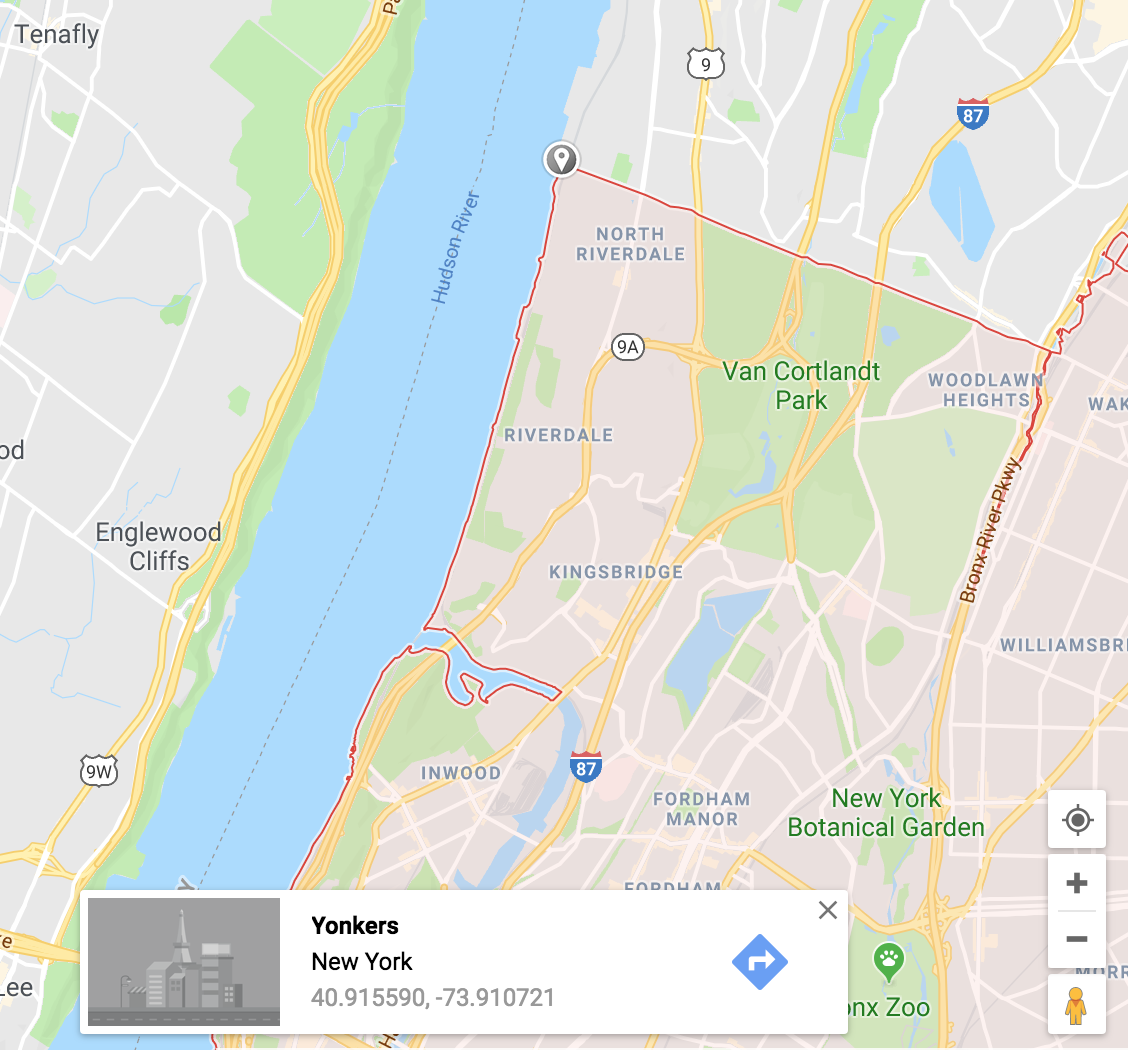

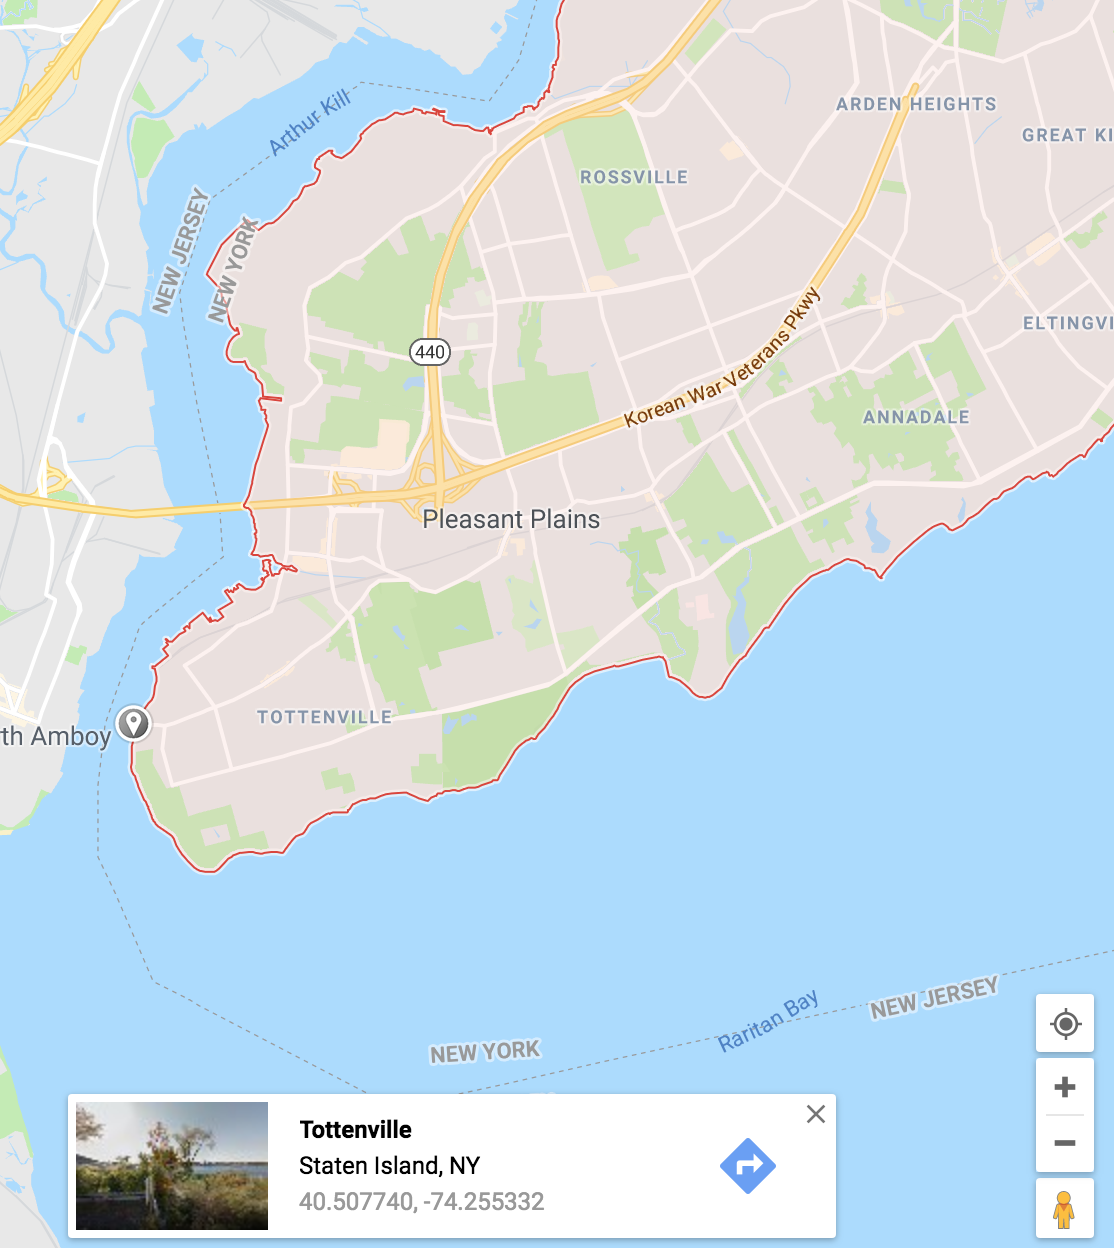

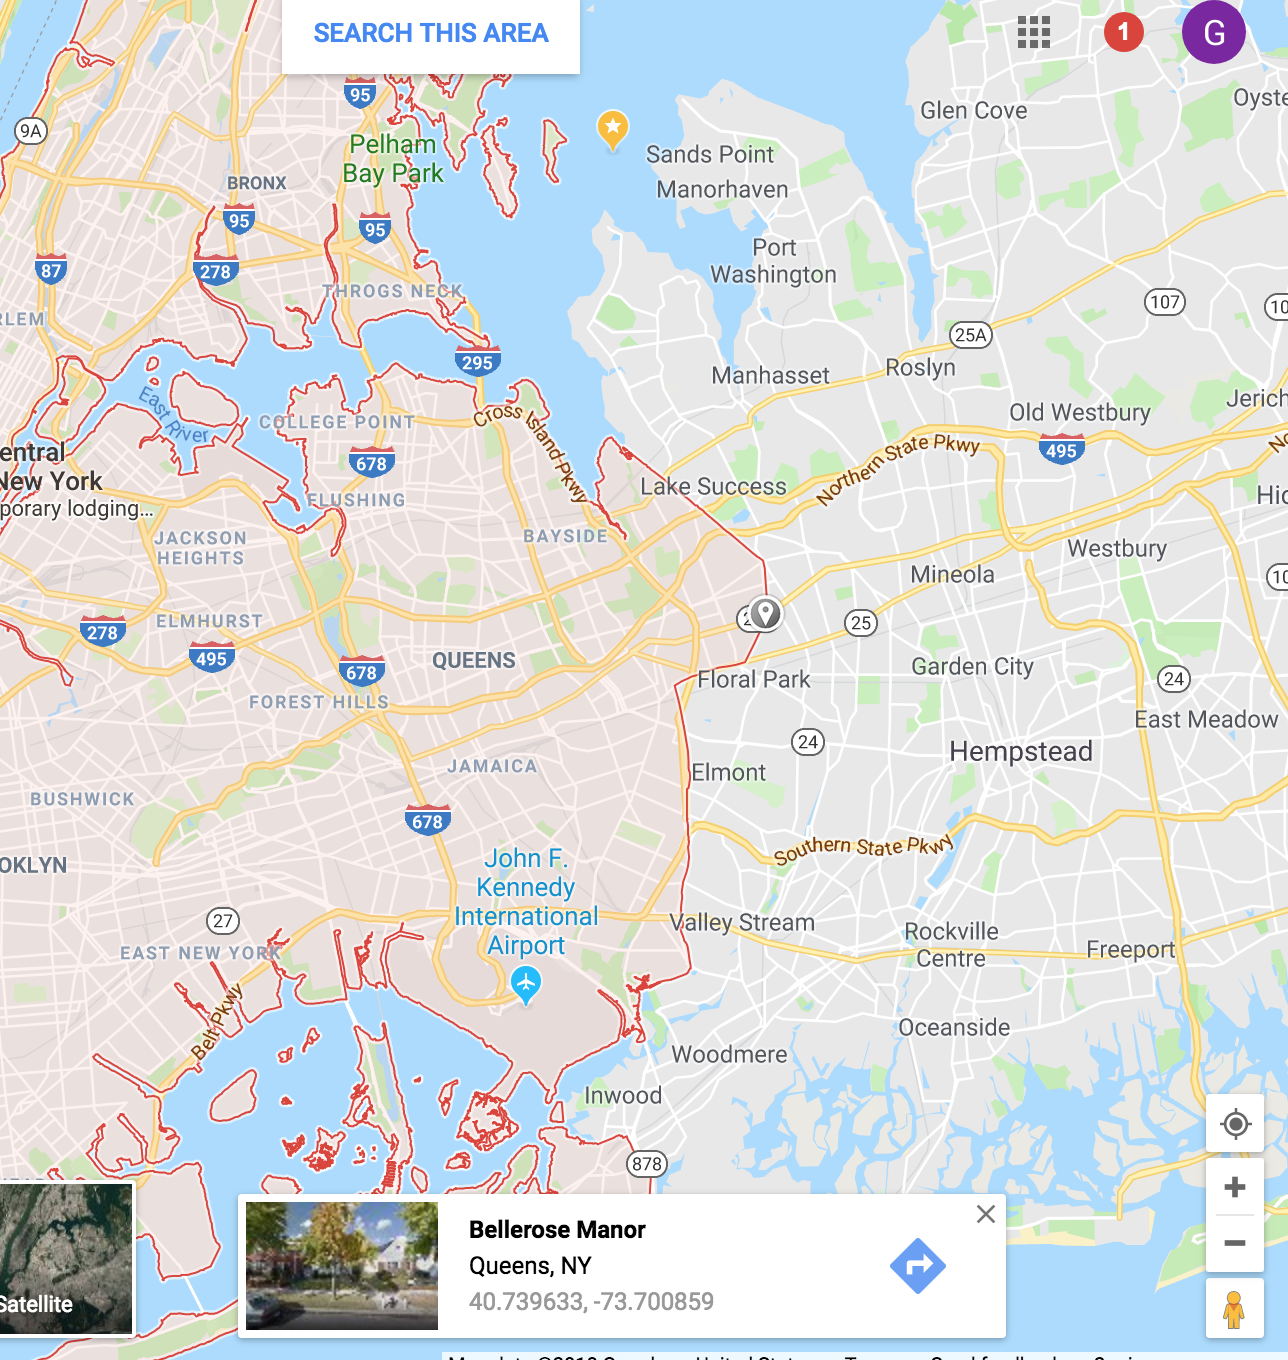

The borders of NY City, in coordinates comes out to be:

city_long_border = (-74.255, -73.701)  
city_lat_border = (40.508, 40.916) 

From the coordinates above, we can limit our area of investigation to within the NY City borders.

In [9]:
city_long_x=-74.255
city_long_y=-73.701
city_lat_x =40.508
city_lat_y=40.916
train = train[train['pickup_longitude'] <= city_long_y]
train = train[train['pickup_longitude'] >= city_long_x]
train = train[train['pickup_latitude'] <= city_lat_y]
train = train[train['pickup_latitude'] >= city_lat_x]
train = train[train['dropoff_longitude'] <= city_long_y]
train = train[train['dropoff_longitude'] >= city_long_x]
train = train[train['dropoff_latitude'] <= city_lat_y]
train = train[train['dropoff_latitude'] >= city_lat_x]

## Check Missing Values 
check whether we have data missing in the train and the test set.

In [10]:
print(train.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [11]:
print(test.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


**Good! no N/A values**

## Check for duplicate ids

In [12]:
print('No of Duplicates, Trip IDs: {}'.format(len(train) - 
                                              len(train.drop_duplicates(subset='id'))))

No of Duplicates, Trip IDs: 0


## Check Number of Passengers
The common sense implies values between 1 and 10, we should check 0

In [13]:
print('Passengers: {} to {}'.format(train.passenger_count.min(), 
                                        train.passenger_count.max()))

Passengers: 0 to 9


## Passenger_Count Clean-up

let's also drop trips with passenger count = 0

In [14]:
print('Empty trips: {}'.format(train[train.passenger_count == 0].shape[0]))
train = train[train.passenger_count > 0]

Empty trips: 59
